In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = None

# Dataset

In [2]:
df = pd.read_csv("data_483_5.csv")
df.index = df['Grid cell']
df.drop(columns=['Grid cell', 'geometry'], inplace=True)
df.dropna(inplace=True)
df.head()

,landuse_green_area,city_level_road,neighborhood_level_road,trail,camera_surveillance_poi,commercial_poi,public_poi,recreation_poi,housing_owner,housing_renter,housing_buld_age_1945_before,housing_buld_age_1946_1990,housing_buld_age_1991_after,housing_small_apartment,housing_large_apartment,housing_standalone_house,housing_auxiliary_house,housing_others,isco_high,isco_medium,isco_low,ethnical_est,ethnical_rus,age_0_9,age_10_19,age_20_29,age_30_39,age_40_49,age_50_59,age_60_69,age_70_79,age_80_89,age_90_plus,landuse_continuous_urban_fabric,landuse_dis_dense_urban,landuse_dis_medium_dense_urban,landuse_industrial_commercial,x_coordinate,y_coordinate,landuse_diversity,crimes_against_public_order,crimes_against_property,total_crime_incidents
Grid cell,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
500mN6579500E534500,87263.047,293.540,4543.525,1051.469,0.0,0.0,2.0,1.0,48,3,0.0,51.0,0.0,1.0,18.0,79.0,0.0,2.0,11,3,9,44,7,3,7,3,7,4,8,8,6,5,0,0.0,109464.280,79694.801,0.000,534749.5,6579749.5,3,0.0,0.0,0.0
500mN6579500E535000,26675.069,28.188,3747.517,371.002,0.0,0.0,0.0,0.0,240,22,0.0,258.0,35.0,1.0,10.0,118.0,0.0,6.0,77,34,44,278,11,27,32,33,38,45,38,38,18,20,4,0.0,14387.668,187514.842,0.000,535249.5,6579749.5,3,3.5,142.5,146.0
500mN6579500E535500,34570.188,1033.767,3472.457,616.484,0.0,3.0,0.0,0.0,297,14,0.0,341.0,27.0,1.0,20.0,70.0,0.0,3.0,48,50,86,339,22,27,40,35,44,45,55,52,45,24,0,0.0,59009.091,113888.838,33783.671,535749.5,6579749.5,4,3.5,142.5,146.0
500mN6579500E536000,115311.402,0.000,1787.774,1831.268,0.0,0.0,0.0,0.0,53,7,0.0,40.0,25.0,0.0,11.0,49.0,1.0,11.0,15,6,6,58,5,8,6,3,4,9,8,8,12,7,0,0.0,1398.917,143772.389,11208.645,536249.5,6579749.5,4,0.0,3.0,3.0
500mN6580000E534500,33491.531,98.575,4174.573,153.976,0.0,0.0,0.0,0.0,77,0,0.0,0.0,78.0,11.0,0.0,113.0,0.0,3.0,36,10,5,68,7,3,12,12,4,11,18,13,6,3,0,0.0,205964.815,4315.367,0.000,534749.5,6580249.5,3,0.0,1.5,1.5


# Pre-processing

In [3]:
hyperparameter_testing = False # if True, will run hyperparameter testing
normalization = False
standardization = False

In [4]:
target = "crimes_against_public_order" # target for prediction

# Three targets for prediction are available, change the target variable to one of the following:
# 'crimes_against_public_order', 
# 'crimes_against_property',
# 'total_crime_incidents'.

In [5]:
target_list = [
    'crimes_against_public_order', 
    'crimes_against_property',
    'total_crime_incidents',
]

if target in target_list:
    target_list.remove(target)
    df_predictors = df.drop(columns=target_list)
    predictors = df_predictors.columns.to_list()
    predictors.remove(target)
    predictor_x = predictors
else:
    print("Target is not a valid target for prediction. Please choose valid target from the list.")



# Data preparation

In [6]:
from sklearn.model_selection import train_test_split

# Control the random seed
random_state = 2024

# Choose the target variable
y = df[target]
print(y.describe())

# Drop the target variable and the id column
x = df[predictor_x]

# Naming for later plotting use
y_name = y.name
x_columns = x.columns


# Normalization
if normalization is True:
    from sklearn.preprocessing import MinMaxScaler
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))

    min_max_scaler.fit(y.values.reshape(-1, 1))

    y = min_max_scaler.transform(y.values.reshape(-1, 1))
else:
    x = x.values


# Convert to numpy arrays for sklearn
# y = y.values

# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.4, random_state= random_state)

count    483.000000
mean      12.637681
std       18.818150
min        0.000000
25%        1.000000
50%        4.000000
75%       18.000000
max      134.000000
Name: crimes_against_public_order, dtype: float64


## Hyperparameter testing


In [7]:
# Tuning: max feature methods

from sklearn.ensemble import RandomForestRegressor

ensemble_regs = [
    (
        "RandomForestRegressor, max_features= Sqrt",
        RandomForestRegressor(
            oob_score= True,
            max_features="sqrt",
            random_state=random_state,
            n_jobs = -1,
        ),
    ),
    (
        "RandomForestRegressor, max_features= log2",
        RandomForestRegressor(
            max_features="log2",
            oob_score= True,
            random_state=random_state,
            n_jobs = -1,
        ),
    ),
    (
        "RandomForestRegressor, max_features= Auto",
        RandomForestRegressor(
            max_features= None,
            oob_score= True,
            random_state=random_state,
            n_jobs = -1,
        ),
    ),
]

In [8]:
# K-fold validation

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits= 10)
scoring = 'r2'

# https://scikit-learn.org/stable/modules/model_evaluation.html

In [9]:
# Tuning: number of trees

if hyperparameter_testing:

    from collections import OrderedDict

    error_list = OrderedDict((label, []) for label, _ in ensemble_regs)
    scoring_list = OrderedDict((label, []) for label, _ in ensemble_regs)
    scoring_test_list = OrderedDict((label, []) for label, _ in ensemble_regs)

    min = 50
    max = 180

    for label, reg in ensemble_regs:
        for i in range(min, max + 1, 10):
            reg.set_params(n_estimators= i)
            reg.fit(x_train, y_train)

            # Record the OOB error
            oob_error = 1 - reg.oob_score_
            error_list[label].append((i, oob_error))
            
            # Record CV
            reg_cv = cross_val_score(reg, x_train, y_train, cv= k_fold, scoring= scoring)
            scoring_list[label].append((i, reg_cv.mean()))
            
            # Record CV with test set
            # reg_cv_test = cross_val_score(reg, x_test, y_test, cv= k_fold, scoring= scoring)
            # scoring_test_list[label].append((i, reg_cv_test.mean()))


    # Collect tuning results
    df_error = pd.concat([pd.DataFrame(error_list['RandomForestRegressor, max_features= Sqrt'], columns=['parameter_sqrt', 'error_sqrt']), pd.DataFrame(error_list['RandomForestRegressor, max_features= log2'], columns=['parameter_log2', 'error_log2']), pd.DataFrame(error_list['RandomForestRegressor, max_features= Auto'], columns= ['parameter_auto', 'error_auto'])], axis= 1)
    df_cv = pd.concat([pd.DataFrame(scoring_list['RandomForestRegressor, max_features= Sqrt'], columns=['parameter_sqrt', 'sqrt']), pd.DataFrame(scoring_list['RandomForestRegressor, max_features= log2'], columns=['parameter_log2', 'log2']), pd.DataFrame(scoring_list['RandomForestRegressor, max_features= Auto'], columns= ['parameter_auto', 'auto'])], axis= 1)
    # df_cv_test = pd.concat([pd.DataFrame(scoring_test_list['RandomForestRegressor, max_features= Sqrt'], columns=['parameter_sqrt', 'sqrt']), pd.DataFrame(scoring_test_list['RandomForestRegressor, max_features= log2'], columns=['parameter_log2', 'log2']), pd.DataFrame(scoring_test_list['RandomForestRegressor, max_features= Auto'], columns= ['parameter_auto', 'auto'])], axis= 1)

    

    plt.plot(df_error['parameter_sqrt'], df_error['error_sqrt'])
    plt.plot(df_error['parameter_log2'], df_error['error_log2'])
    plt.plot(df_error['parameter_auto'], df_error['error_auto'])

    plt.xlabel('Number of Trees')
    plt.ylabel('OOB Error Rate')
    plt.legend(['sqrt', 'log2', 'auto'])
    plt.show()

    plt.plot(df_cv['parameter_sqrt'], df_cv['sqrt'])
    plt.plot(df_cv['parameter_log2'], df_cv['log2'])
    plt.plot(df_cv['parameter_auto'], df_cv['auto'])
    # plt.plot(df_cv_test['parameter_sqrt'], df_cv_test['sqrt'])
    # plt.plot(df_cv_test['parameter_log2'], df_cv_test['log2'])
    # plt.plot(df_cv_test['parameter_auto'], df_cv_test['auto'])
    
    plt.xlabel('Number of Trees')
    plt.ylabel(scoring)
    plt.legend(['sqrt', 'log2', 'auto',]) # 'sqrt_test', 'log2_test', 'auto_test'])
    plt.show()

# df_error.to_csv(f'result_3_tree_{target}.csv')
# df_cv.to_csv(f'result_3_cv_tree_{target}.csv')


In [10]:
# Tuning: depth of trees

if hyperparameter_testing:

    from collections import OrderedDict

    error_list = OrderedDict((label, []) for label, _ in ensemble_regs)
    scoring_list = OrderedDict((label, []) for label, _ in ensemble_regs)
    # scoring_test_list = OrderedDict((label, []) for label, _ in ensemble_regs)

    min = 5
    max = 30

    for label, reg in ensemble_regs:
        for i in range(min, max + 1, 1):
            reg.set_params(max_depth= i)
            reg.fit(x_train, y_train)

            # Record the OOB error
            oob_error = 1 - reg.oob_score_
            error_list[label].append((i, oob_error))
            
            # Record CV
            reg_cv = cross_val_score(reg, x_train, y_train, cv= k_fold, scoring= scoring)
            scoring_list[label].append((i, reg_cv.mean()))
            
            # Record CV with test set
            # reg_cv_test = cross_val_score(reg, x_test, y_test, cv= k_fold, scoring= scoring)
            # scoring_test_list[label].append((i, reg_cv_test.mean()))


    # Collect tuning results
    df_error = pd.concat([pd.DataFrame(error_list['RandomForestRegressor, max_features= Sqrt'], columns=['parameter_sqrt', 'error_sqrt']), pd.DataFrame(error_list['RandomForestRegressor, max_features= log2'], columns=['parameter_log2', 'error_log2']), pd.DataFrame(error_list['RandomForestRegressor, max_features= Auto'], columns= ['parameter_auto', 'error_auto'])], axis= 1)
    df_cv = pd.concat([pd.DataFrame(scoring_list['RandomForestRegressor, max_features= Sqrt'], columns=['parameter_sqrt', 'sqrt']), pd.DataFrame(scoring_list['RandomForestRegressor, max_features= log2'], columns=['parameter_log2', 'log2']), pd.DataFrame(scoring_list['RandomForestRegressor, max_features= Auto'], columns= ['parameter_auto', 'auto'])], axis= 1)
    # df_cv_test = pd.concat([pd.DataFrame(scoring_test_list['RandomForestRegressor, max_features= Sqrt'], columns=['parameter_sqrt', 'sqrt']), pd.DataFrame(scoring_test_list['RandomForestRegressor, max_features= log2'], columns=['parameter_log2', 'log2']), pd.DataFrame(scoring_test_list['RandomForestRegressor, max_features= Auto'], columns= ['parameter_auto', 'auto'])], axis= 1)


    plt.plot(df_error['parameter_sqrt'], df_error['error_sqrt'])
    plt.plot(df_error['parameter_log2'], df_error['error_log2'])
    plt.plot(df_error['parameter_auto'], df_error['error_auto'])

    plt.xlabel('Depth of Trees')
    plt.ylabel('OOB Error Rate')
    plt.legend(['sqrt', 'log2', 'auto'])
    plt.show()

 
    plt.plot(df_cv['parameter_sqrt'], df_cv['sqrt'])
    # plt.plot(df_cv_test['parameter_sqrt'], df_cv_test['sqrt'])
    plt.plot(df_cv['parameter_log2'], df_cv['log2'])
    # plt.plot(df_cv_test['parameter_log2'], df_cv_test['log2'])
    plt.plot(df_cv['parameter_auto'], df_cv['auto'])
    # plt.plot(df_cv_test['parameter_auto'], df_cv_test['auto'])
    
    plt.xlabel('Depth of Trees')
    plt.ylabel(scoring)
    plt.legend(['sqrt', 'log2', 'auto',])# 'sqrt_test', 'log2_test', 'auto_test'])
    
# df_error.to_csv(f'result_3_depth_{target}.csv')
# df_cv.to_csv(f'result_3_cv_depth_{target}.csv')


In [11]:
# # Tuning: Max leaf nodes

if hyperparameter_testing:

    from collections import OrderedDict

    error_list = OrderedDict((label, []) for label, _ in ensemble_regs)
    scoring_list = OrderedDict((label, []) for label, _ in ensemble_regs)
    # scoring_test_list = OrderedDict((label, []) for label, _ in ensemble_regs)

    min = 2
    max = 10

    for label, reg in ensemble_regs:
        for i in range(min, max + 1, 1):
            reg.set_params(max_leaf_nodes= i)
            reg.fit(x_train, y_train)

            # Record the OOB error 
            oob_error = 1 - reg.oob_score_
            error_list[label].append((i, oob_error))
            
            # Record CV
            reg_cv = cross_val_score(reg, x_train, y_train, cv= k_fold, scoring= scoring)
            scoring_list[label].append((i, reg_cv.mean()))
            
            # Record CV with test set
            # reg_cv_test = cross_val_score(reg, x_test, y_test, cv= k_fold, scoring= scoring)
            # scoring_test_list[label].append((i, reg_cv_test.mean()))


    # Collect tuning results
    df_error = pd.concat([pd.DataFrame(error_list['RandomForestRegressor, max_features= Sqrt'], columns=['parameter_sqrt', 'error_sqrt']), pd.DataFrame(error_list['RandomForestRegressor, max_features= log2'], columns=['parameter_log2', 'error_log2']), pd.DataFrame(error_list['RandomForestRegressor, max_features= Auto'], columns= ['parameter_auto', 'error_auto'])], axis= 1)
    df_cv = pd.concat([pd.DataFrame(scoring_list['RandomForestRegressor, max_features= Sqrt'], columns=['parameter_sqrt', 'sqrt']), pd.DataFrame(scoring_list['RandomForestRegressor, max_features= log2'], columns=['parameter_log2', 'log2']), pd.DataFrame(scoring_list['RandomForestRegressor, max_features= Auto'], columns= ['parameter_auto', 'auto'])], axis= 1)
    # df_cv_test = pd.concat([pd.DataFrame(scoring_test_list['RandomForestRegressor, max_features= Sqrt'], columns=['parameter_sqrt', 'sqrt']), pd.DataFrame(scoring_test_list['RandomForestRegressor, max_features= log2'], columns=['parameter_log2', 'log2']), pd.DataFrame(scoring_test_list['RandomForestRegressor, max_features= Auto'], columns= ['parameter_auto', 'auto'])], axis= 1)


    plt.plot(df_error['parameter_sqrt'], df_error['error_sqrt'])
    plt.plot(df_error['parameter_log2'], df_error['error_log2'])
    plt.plot(df_error['parameter_auto'], df_error['error_auto'])

    plt.xlabel('Number of leaves in a node')
    plt.ylabel('OOB Error Rate')
    plt.legend(['sqrt', 'log2', 'auto'])
    plt.show()


    plt.plot(df_cv['parameter_sqrt'], df_cv['sqrt'])
    # plt.plot(df_cv_test['parameter_sqrt'], df_cv_test['sqrt'])
    plt.plot(df_cv['parameter_log2'], df_cv['log2'])
    # plt.plot(df_cv_test['parameter_log2'], df_cv_test['log2'])
    plt.plot(df_cv['parameter_auto'], df_cv['auto'])
    # plt.plot(df_cv_test['parameter_auto'], df_cv_test['auto'])
    
    plt.xlabel('Number of leaves in a node')
    plt.ylabel(scoring)
    plt.legend(['sqrt', 'log2', 'auto',])# 'sqrt_test', 'log2_test', 'auto_test'])
    
# df_error.to_csv(f'result_3_max_leaf_{target}.csv')
# df_cv.to_csv(f'result_3_cv_max_leaf_{target}.csv')

In [12]:
# Tuning: min_samples_split

if hyperparameter_testing:

    from collections import OrderedDict

    error_sample = OrderedDict((label, []) for label, _ in ensemble_regs)
    scoring_sample = OrderedDict((label, []) for label, _ in ensemble_regs)
    # scoring_sample_test = OrderedDict((label, []) for label, _ in ensemble_regs)

    min_sample = 2
    max_sample = 20

    for label, reg in ensemble_regs:
        for i in range(min_sample, max_sample + 1, 1):
            reg.set_params(min_samples_split= i)
            reg.fit(x_train, y_train)

            # Record the OOB error
            oob_error = 1 - reg.oob_score_
            error_sample[label].append((i, oob_error))
            
            # Record CV
            reg_cv = cross_val_score(reg, x_train, y_train, cv= k_fold, scoring= scoring)
            scoring_sample[label].append((i, reg_cv.mean()))
            
            # Record CV with test set
            # reg_cv_test = cross_val_score(reg, x_test, y_test, cv= k_fold, scoring= scoring)
            # scoring_sample_test[label].append((i, reg_cv_test.mean()))


    # Collect tuning results
    df_sample_error = pd.concat([pd.DataFrame(error_sample['RandomForestRegressor, max_features= Sqrt'], columns=['sample_sqrt', 'error_sqrt']), pd.DataFrame(error_sample['RandomForestRegressor, max_features= log2'], columns=['sample_log2', 'error_log2']), pd.DataFrame(error_sample['RandomForestRegressor, max_features= Auto'], columns= ['sample_auto', 'error_auto'])], axis= 1)
    df_sample_cv = pd.concat([pd.DataFrame(scoring_sample['RandomForestRegressor, max_features= Sqrt'], columns=['sample_sqrt', 'sqrt']), pd.DataFrame(scoring_sample['RandomForestRegressor, max_features= log2'], columns=['sample_log2', 'log2']), pd.DataFrame(scoring_sample['RandomForestRegressor, max_features= Auto'], columns= ['sample_auto', 'auto'])], axis= 1)
    # df_sample_cv_test = pd.concat([pd.DataFrame(scoring_sample_test['RandomForestRegressor, max_features= Sqrt'], columns=['sample_sqrt', 'sqrt']), pd.DataFrame(scoring_sample_test['RandomForestRegressor, max_features= log2'], columns=['sample_log2', 'log2']), pd.DataFrame(scoring_sample_test['RandomForestRegressor, max_features= Auto'], columns= ['sample_auto', 'auto'])], axis= 1)


    plt.plot(df_sample_error['sample_sqrt'], df_sample_error['error_sqrt'])
    plt.plot(df_sample_error['sample_log2'], df_sample_error['error_log2'])
    plt.plot(df_sample_error['sample_auto'], df_sample_error['error_auto'])

    plt.xlabel('Number of sample for splitting')
    plt.ylabel('OOB Error Rate')
    plt.legend(['sqrt', 'log2', 'auto'])
    plt.show()

    plt.plot(df_sample_cv['sample_sqrt'], df_sample_cv['sqrt'])
    # plt.plot(df_sample_cv_test['sample_sqrt'], df_sample_cv_test['sqrt'])
    plt.plot(df_sample_cv['sample_log2'], df_sample_cv['log2'])
    # plt.plot(df_sample_cv_test['sample_log2'], df_sample_cv_test['log2'])
    plt.plot(df_sample_cv['sample_auto'], df_sample_cv['auto'])
    # plt.plot(df_sample_cv_test['sample_auto'], df_sample_cv_test['auto'])
    
    plt.xlabel('Number of sample for splitting')
    plt.ylabel(scoring)
    plt.legend(['sqrt', 'log2', 'auto',]) # 'sqrt_test', 'log2_test', 'auto_test'])
    plt.show()
    
# df_error.to_csv(f'result_3_min_split_{target}.csv')
# df_cv.to_csv(f'result_3_cv_min_split_{target}.csv')

In [13]:
# Tuning: min_samples_leaf

if hyperparameter_testing:

    from collections import OrderedDict

    error_list = OrderedDict((label, []) for label, _ in ensemble_regs)
    scoring_list = OrderedDict((label, []) for label, _ in ensemble_regs)
    # scoring_test_list = OrderedDict((label, []) for label, _ in ensemble_regs)

    min = 2
    max = 20

    for label, reg in ensemble_regs:
        for i in range(min, max + 1, 1):
            reg.set_params(min_samples_leaf= i)
            reg.fit(x_train, y_train)

            # Record the OOB error
            oob_error = 1 - reg.oob_score_
            error_list[label].append((i, oob_error))
            
            # Record CV
            reg_cv = cross_val_score(reg, x_train, y_train, cv= k_fold, scoring= scoring)
            scoring_list[label].append((i, reg_cv.mean()))
            
            # Record CV with test set
            # reg_cv_test = cross_val_score(reg, x_test, y_test, cv= k_fold, scoring= scoring)
            # scoring_test_list[label].append((i, reg_cv_test.mean()))


    # Collect tuning results
    df_error = pd.concat([pd.DataFrame(error_list['RandomForestRegressor, max_features= Sqrt'], columns=['parameter_sqrt', 'error_sqrt']), pd.DataFrame(error_list['RandomForestRegressor, max_features= log2'], columns=['parameter_log2', 'error_log2']), pd.DataFrame(error_list['RandomForestRegressor, max_features= Auto'], columns= ['parameter_auto', 'error_auto'])], axis= 1)
    df_cv = pd.concat([pd.DataFrame(scoring_list['RandomForestRegressor, max_features= Sqrt'], columns=['parameter_sqrt', 'sqrt']), pd.DataFrame(scoring_list['RandomForestRegressor, max_features= log2'], columns=['parameter_log2', 'log2']), pd.DataFrame(scoring_list['RandomForestRegressor, max_features= Auto'], columns= ['parameter_auto', 'auto'])], axis= 1)
    # df_cv_test = pd.concat([pd.DataFrame(scoring_test_list['RandomForestRegressor, max_features= Sqrt'], columns=['parameter_sqrt', 'sqrt']), pd.DataFrame(scoring_test_list['RandomForestRegressor, max_features= log2'], columns=['parameter_log2', 'log2']), pd.DataFrame(scoring_test_list['RandomForestRegressor, max_features= Auto'], columns= ['parameter_auto', 'auto'])], axis= 1)


    plt.plot(df_error['parameter_sqrt'], df_error['error_sqrt'])
    plt.plot(df_error['parameter_log2'], df_error['error_log2'])
    plt.plot(df_error['parameter_auto'], df_error['error_auto'])

    plt.xlabel('Number of samples in a leaf')
    plt.ylabel('OOB Error Rate')
    plt.legend(['sqrt', 'log2', 'auto'])
    plt.show()


    plt.plot(df_cv['parameter_sqrt'], df_cv['sqrt'])
    # plt.plot(df_cv_test['parameter_sqrt'], df_cv_test['sqrt'])
    plt.plot(df_cv['parameter_log2'], df_cv['log2'])
    # plt.plot(df_cv_test['parameter_log2'], df_cv_test['log2'])
    plt.plot(df_cv['parameter_auto'], df_cv['auto'])
    # plt.plot(df_cv_test['parameter_auto'], df_cv_test['auto'])
    
    plt.xlabel('Number of samples in a leaf')
    plt.ylabel(scoring)
    plt.legend(['sqrt', 'log2', 'auto',]) # 'sqrt_test', 'log2_test', 'auto_test'])
    plt.show()
    
# df_error.to_csv(f'result_3_min_leaf_{target}.csv')
# df_cv.to_csv(f'result_3_cv_min_leaf_{target}.csv')

# Modeling

In [15]:
# Change the tree number, depth, and maximum feature method here
tree_number = 100
tree_depth = 7 #12
max_feature_method = None
# 'sqrt', 'log2', and None for auto

max_leaf_nodes = 5 #4
min_samples_split = 7
min_samples_leaf = 5
# max_samples = 50



from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

f_regmodel = RandomForestRegressor(
    n_estimators= tree_number,  # Trees
    random_state= random_state, 
    criterion='squared_error', 
    max_depth= tree_depth, # Depth
    max_features= max_feature_method,
    oob_score= True,
    max_leaf_nodes = max_leaf_nodes,
    min_samples_split = min_samples_split,
    min_samples_leaf = min_samples_leaf,
    # max_samples= max_samples,
    )

# standardlize
if standardization is True:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

reg = f_regmodel.fit(x_train, y_train)

predict_list = list(reg.predict(x_train))
y_train_list = list(y_train)

predict_test_list = list(reg.predict(x_test))
y_test_list = list(y_test)


print('Training data validation for {}:\nR2: {} \nRMSE: {} \nMAE: {}\n'.format(target, r2_score(y_train_list, predict_list), mean_squared_error(y_train_list, predict_list, squared=False), mean_absolute_error(y_train_list, predict_list)))
print('Test data validation for {}:\nR2: {} \nRMSE: {} \nMAE: {}'.format(target, r2_score(y_test_list, predict_test_list), mean_squared_error(y_test_list, predict_test_list, squared=False), mean_absolute_error(y_test_list, predict_test_list)))

Training data validation for crimes_against_public_order:
R2: 0.8269976586148833 
RMSE: 7.743459359908811 
MAE: 4.366280801464175

Test data validation for crimes_against_public_order:
R2: 0.6316489984385882 
RMSE: 11.564965281172912 
MAE: 5.972510273705225


/Users/ansel/micromamba/envs/geopython2023/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ansel/micromamba/envs/geopython2023/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Results

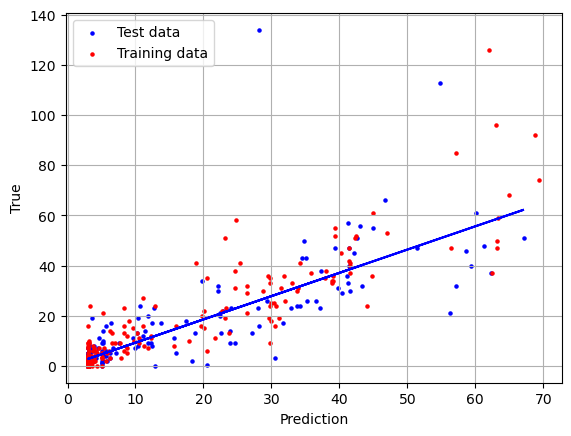

In [16]:
import numpy as np
plt.scatter(predict_test_list, y_test_list, s= 5, c= 'blue')
plt.scatter(predict_list, y_train_list, s= 5, c= 'red')

plt.xlabel('Prediction')
plt.ylabel('True')
plt.grid()
plt.legend(['Test data', 'Training data'])

m, b = np.polyfit(predict_test_list, y_test_list, 1)
plt.plot(predict_test_list, m*np.array(predict_test_list) + b, color= 'blue')


plt.show()

## Residuals

In [17]:
# Prepare all data without splitting training and testing
y_val = df[target]
x_val = df[predictor_x]

# Naming for later plotting use
# y_val_name = y_val.name
# x_val_columns = x_val.columns

# Normalization (based on the modeling setting)
if normalization is True:
    from sklearn.preprocessing import MinMaxScaler
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    x_val = min_max_scaler.fit_transform(x_val.values, y_val.values)
else:
    x_val = x_val.values


<Axes: >

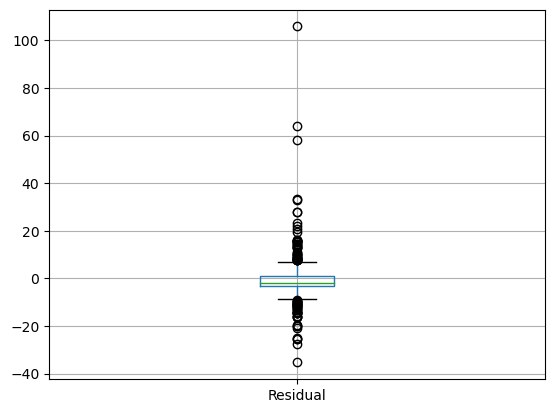

In [18]:
# Calculate the residual

# Predict the validation data
y_val_predict_list = list(reg.predict(x_val))
y_val_list = list(y_val.values)

# print('SAC Validation:\nR2: {} \nRMSE: {} \nMAE: {}\n'.format(r2_score(y_val_list, x_val_predict_list), mean_squared_error(y_val_list, x_val_predict_list, squared=False), mean_absolute_error(y_val_list, x_val_predict_list)))

y_val_residual = y_val.values - y_val_predict_list
y_val_residual = pd.DataFrame(y_val_residual, columns= ['Residual'], index= y_val.index)

y_val_residual.boxplot()

<Axes: ylabel='Frequency'>

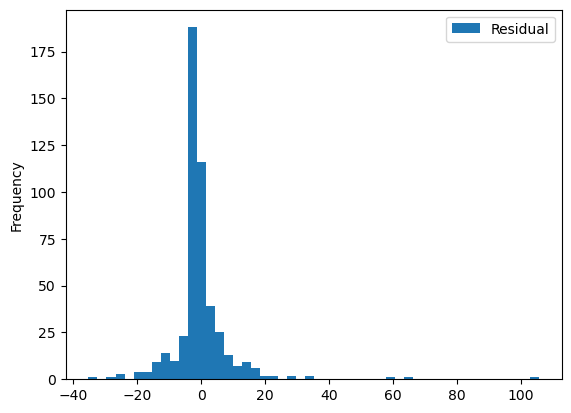

In [19]:
y_val_residual.plot.hist(bins= 50)

In [20]:
# Save the residual

# y_val_residual.to_csv(f'residual_3_{target}_{tree_number}_{tree_depth}_{max_feature_method}_{max_leaf_nodes}.csv')
# gdf.to_file(f"residual_3_{target}_{tree_number}_{tree_depth}_{max_feature_method}_{max_leaf_nodes}.geojson", driver= 'GeoJSON')

## Autocorrelation

In [21]:
import geopandas as gpd
gdf = gpd.read_file("grid_483_5.geojson")


In [22]:
# Join gdf and residual by grid cell
gdf = gdf.join(y_val_residual, on= 'Grid cell')
gdf.head()

,Grid cell,X,Y,geometry,Residual
0,500mN6579500E534500,534749.5,6579749.5,"POLYGON ((534500.000 6579500.000, 534500.000 6...",-3.079855
1,500mN6579500E535000,535249.5,6579749.5,"POLYGON ((535000.000 6579500.000, 535000.000 6...",0.420145
2,500mN6579500E535500,535749.5,6579749.5,"POLYGON ((535500.000 6579500.000, 535500.000 6...",0.041957
3,500mN6579500E536000,536249.5,6579749.5,"POLYGON ((536000.000 6579500.000, 536000.000 6...",-3.079855
4,500mN6580000E534500,534749.5,6580249.5,"POLYGON ((534500.000 6580000.000, 534500.000 6...",-3.079855


<Axes: >

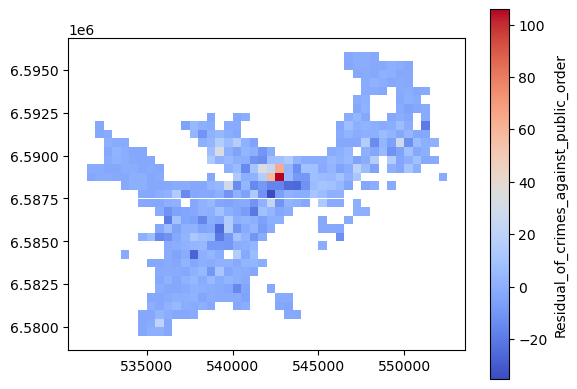

In [23]:
gdf.plot(column= 'Residual', legend= True, cmap= 'coolwarm', legend_kwds= {'label': f'Residual_of_{target}'})

In [24]:
# Calculate the Moran's I
import libpysal
from esda.moran import Moran

xy = gdf[['X', 'Y']].values
w = libpysal.weights.DistanceBand.from_array(xy, threshold= 500, binary= False)
# w = libpysal.weights.KNN.from_dataframe(gdf, k= 8)
y = gdf['Residual']

moran = Moran(y, w)
moran.I

/Users/ansel/micromamba/envs/geopython2023/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/Users/ansel/micromamba/envs/geopython2023/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/Users/ansel/microm

('WARNING: ', 57, ' is an island (no neighbors)')
('WARNING: ', 95, ' is an island (no neighbors)')
('WARNING: ', 117, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 261, ' is an island (no neighbors)')
('WARNING: ', 287, ' is an island (no neighbors)')


/Users/ansel/micromamba/envs/geopython2023/lib/python3.10/site-packages/scipy/sparse/_data.py:132: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/Users/ansel/micromamba/envs/geopython2023/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 11 disconnected components.
 There are 6 islands with ids: 57, 95, 117, 166, 261, 287.
  warnings.warn(message)


0.23454959499389008

In [25]:
moran.p_sim

0.001

In [26]:
moran.z_sim

6.648406212959115

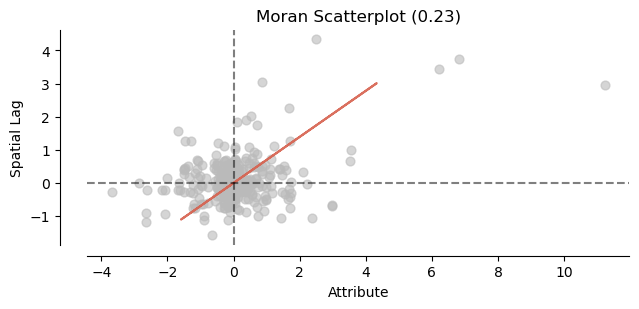

In [27]:
# Make a Moran scatter plot
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran, aspect_equal= True)
plt.show()

## Important Factors

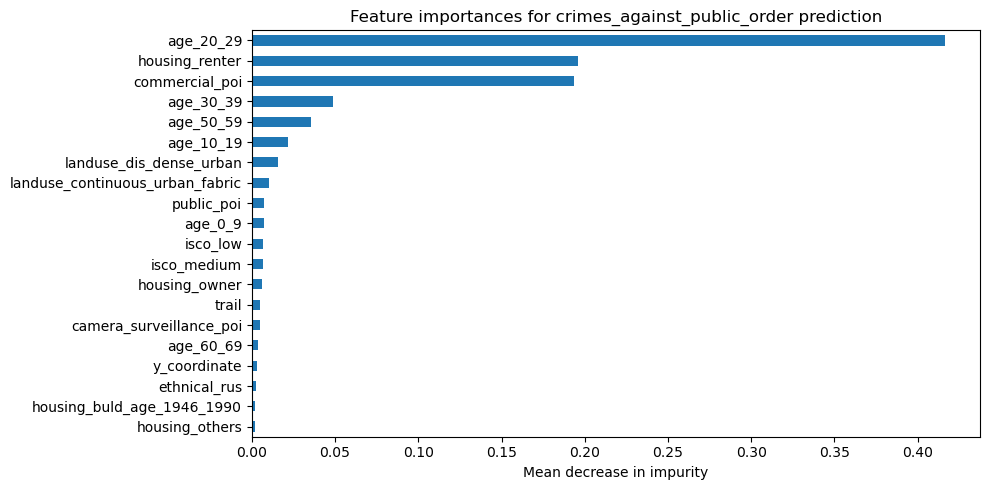

In [28]:
import numpy as np

importances = reg.feature_importances_
forest_importances = pd.Series(importances, index=x_columns).sort_values(ascending=True).tail(20)


fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
forest_importances.plot.barh(ax = ax)
ax.set_title("Feature importances for {} prediction".format(y_name))
ax.set_xlabel("Mean decrease in impurity")

fig.tight_layout()

In [29]:
df_forest_importance = pd.DataFrame(forest_importances)
df_forest_importance.columns = ['Score']
df_forest_importance = df_forest_importance.sort_values(by= 'Score', ascending= False)

# df_forest_importance.to_csv(f'result_importance_{target}_{tree_number}_{tree_depth}_{max_feature_method}.csv', index= False)
df_forest_importance

,Score
age_20_29,0.416642
housing_renter,0.195792
commercial_poi,0.193353
age_30_39,0.048489
age_50_59,0.035546
age_10_19,0.021522
landuse_dis_dense_urban,0.015971
landuse_continuous_urban_fabric,0.010433
public_poi,0.007494
age_0_9,0.007078


## SHAP

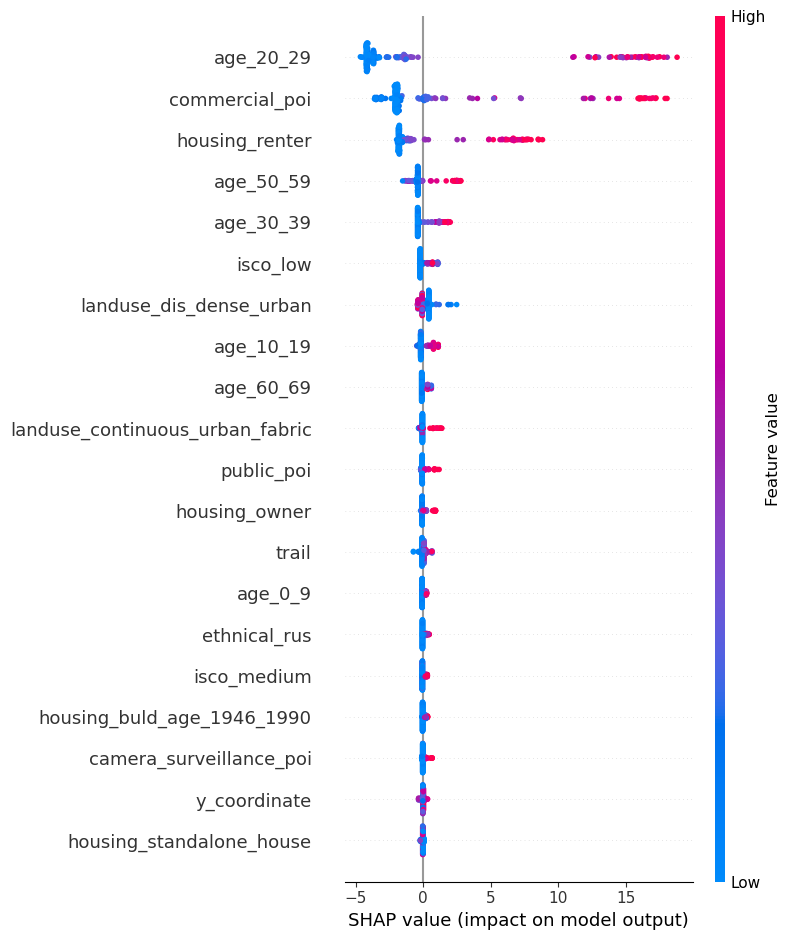

In [30]:
import shap
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values, x_test, feature_names=x_columns, plot_type= 'dot')

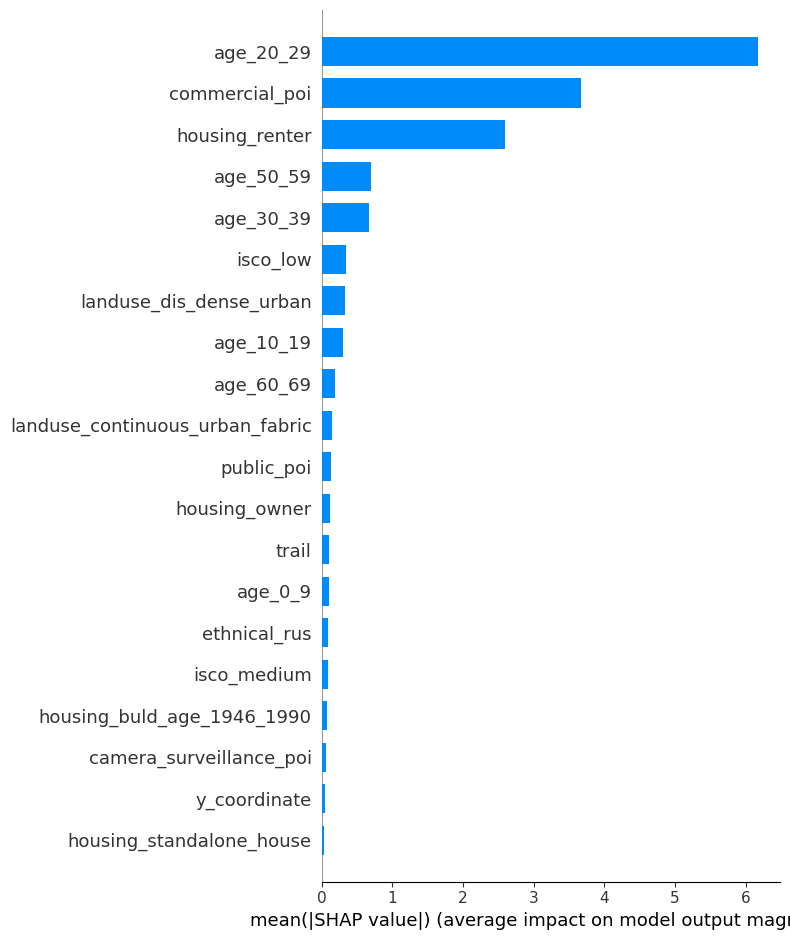

In [31]:
shap.summary_plot(shap_values, x_test, feature_names=x_columns, plot_type="bar")

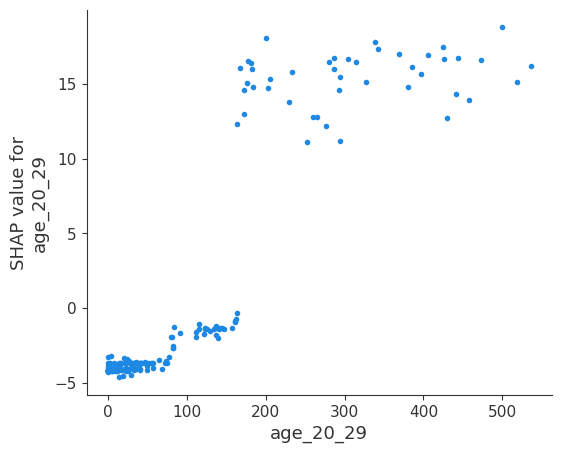

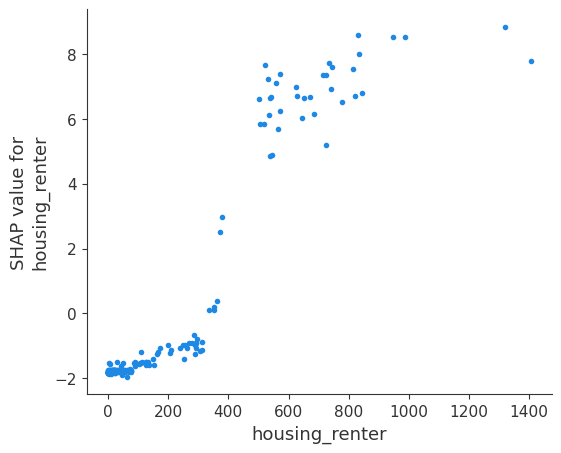

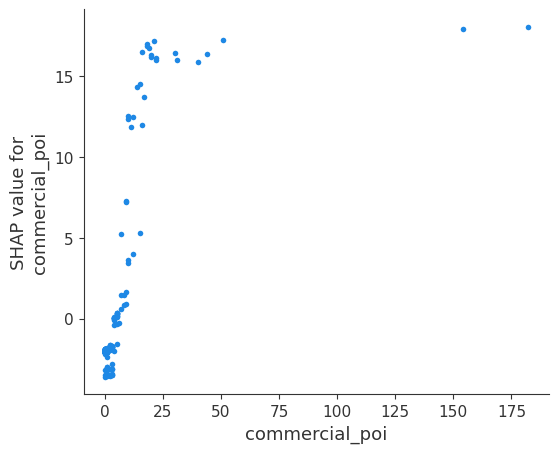

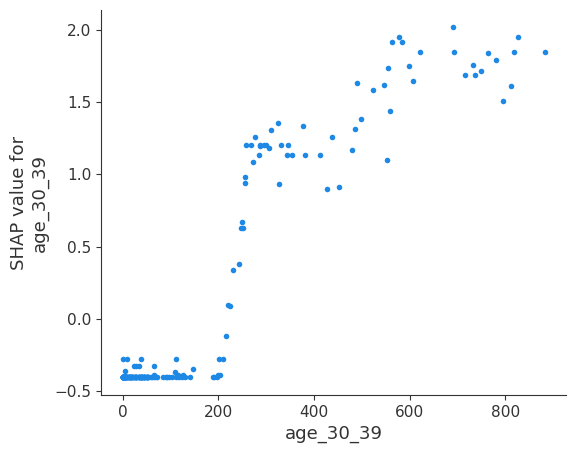

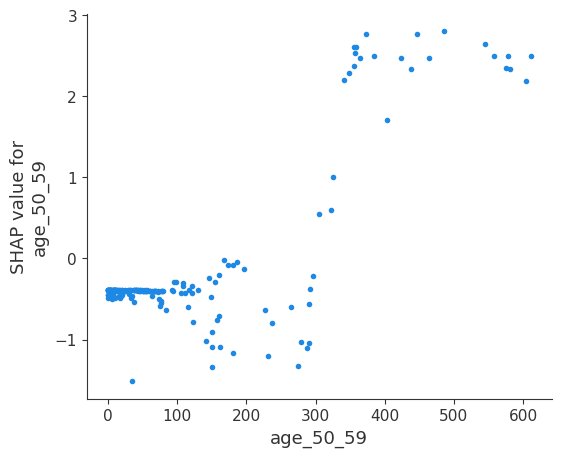

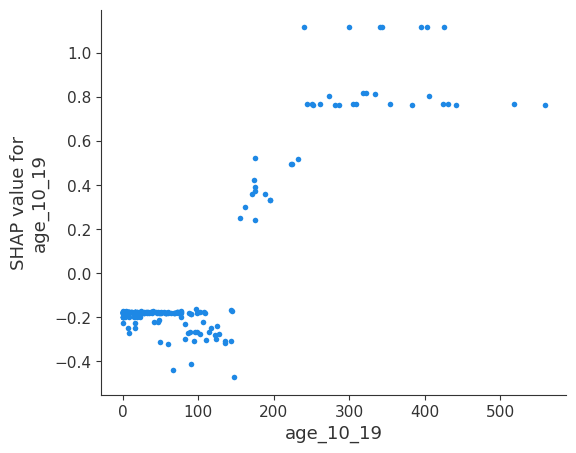

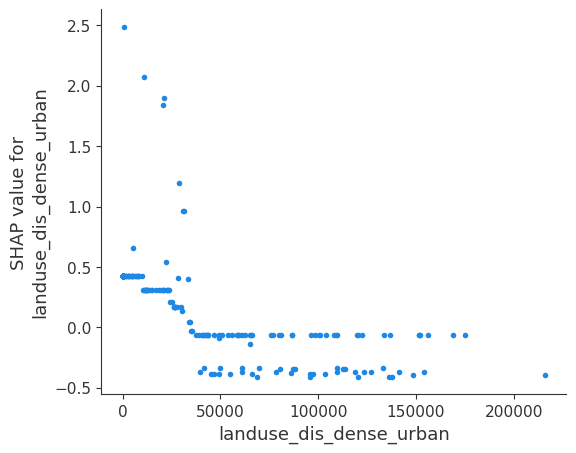

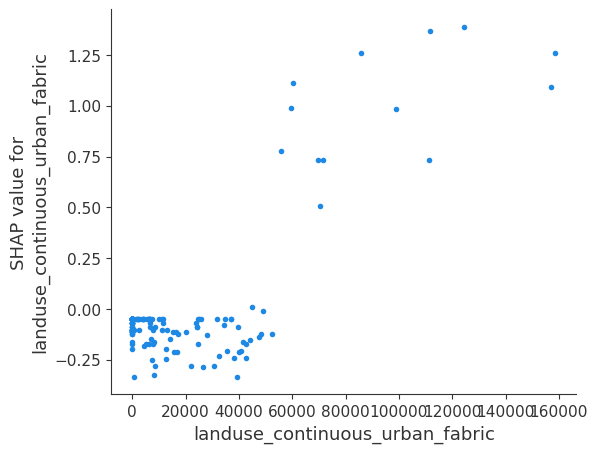

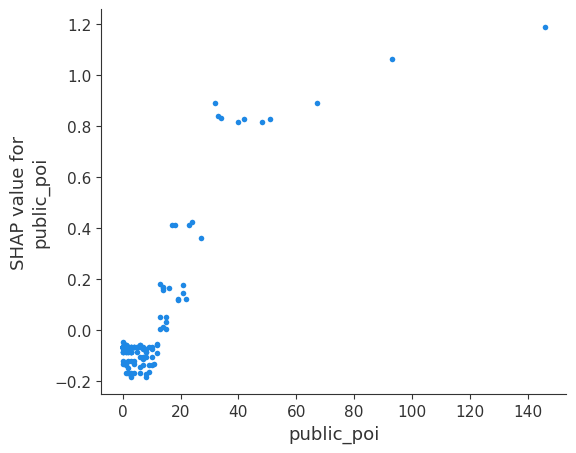

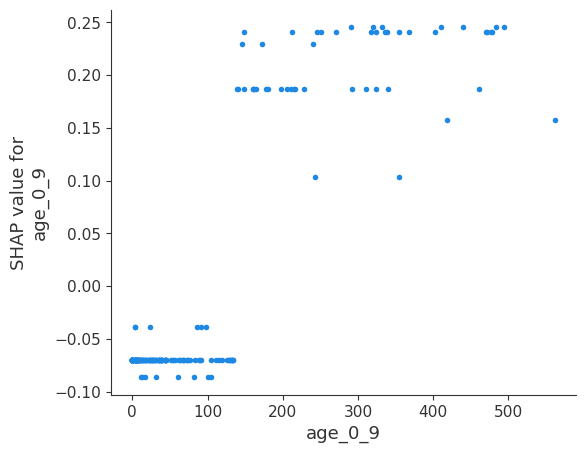

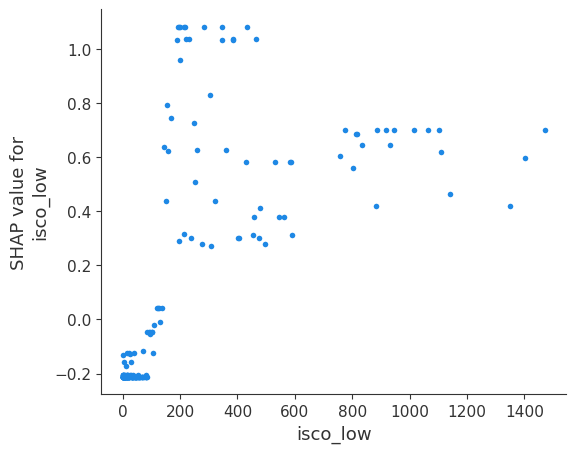

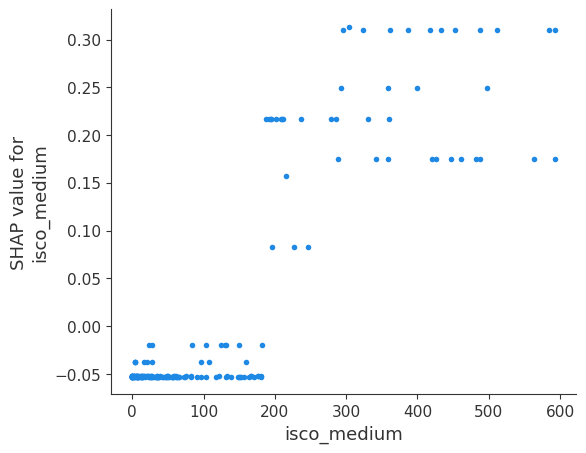

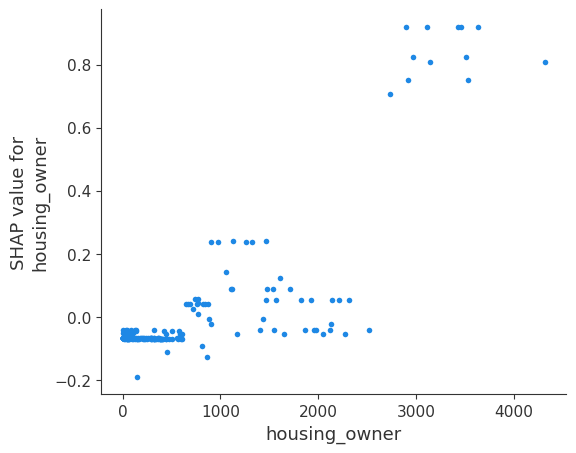

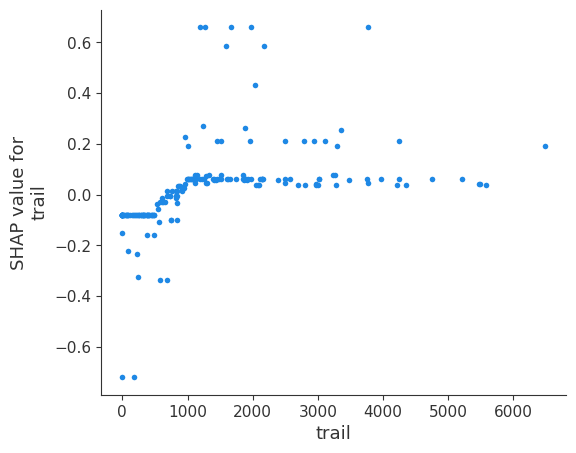

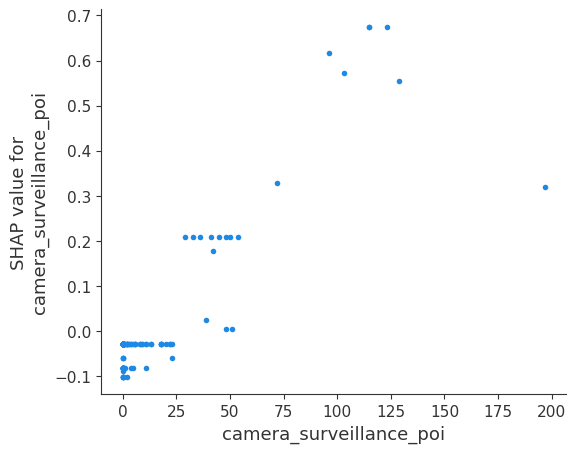

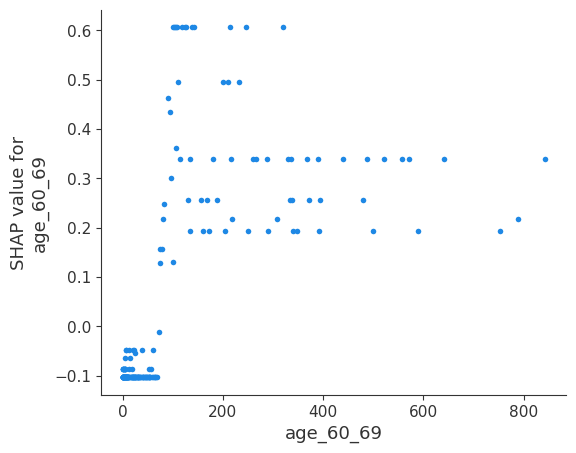

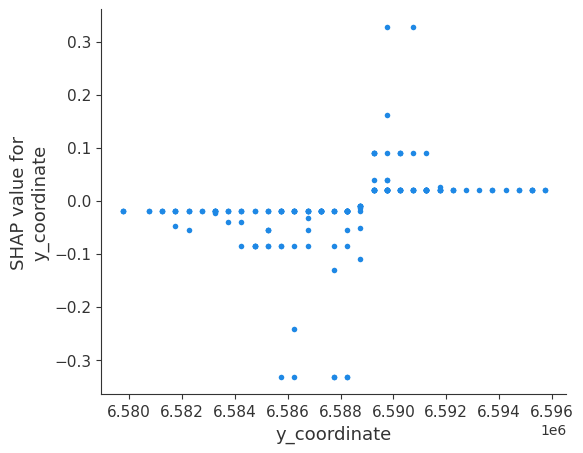

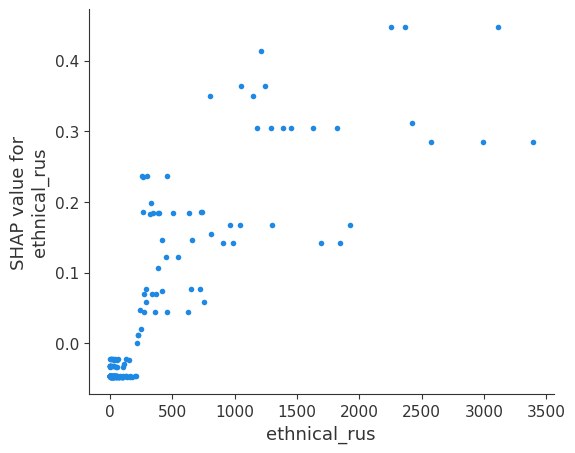

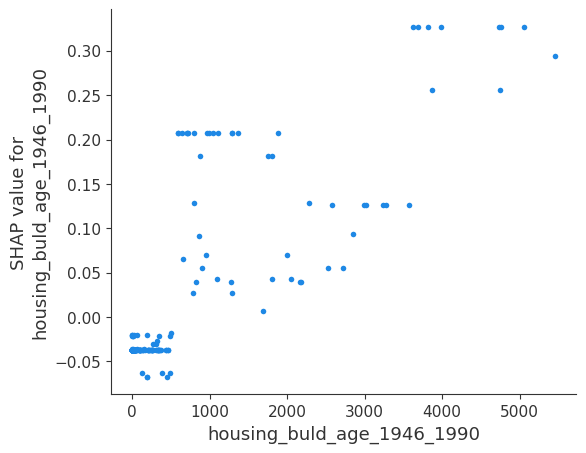

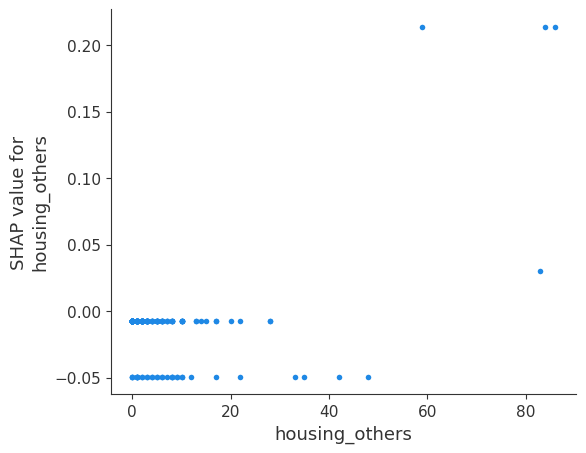

In [32]:
for i in df_forest_importance.index:
    shap.dependence_plot(i, shap_values, x_test, feature_names=x_columns, interaction_index= None)


In [33]:
df_shap_values = pd.DataFrame(shap_values, columns= x_columns)
df_shap_values

,landuse_green_area,city_level_road,neighborhood_level_road,trail,camera_surveillance_poi,commercial_poi,public_poi,recreation_poi,housing_owner,housing_renter,housing_buld_age_1945_before,housing_buld_age_1946_1990,housing_buld_age_1991_after,housing_small_apartment,housing_large_apartment,housing_standalone_house,housing_auxiliary_house,housing_others,isco_high,isco_medium,isco_low,ethnical_est,ethnical_rus,age_0_9,age_10_19,age_20_29,age_30_39,age_40_49,age_50_59,age_60_69,age_70_79,age_80_89,age_90_plus,landuse_continuous_urban_fabric,landuse_dis_dense_urban,landuse_dis_medium_dense_urban,landuse_industrial_commercial,x_coordinate,y_coordinate,landuse_diversity
0,0.070653,0.0,0.0,0.038555,-0.080904,-3.471089,0.049653,-0.022387,0.918992,8.531390,0.0,0.326962,0.0,0.0,0.0,0.052812,0.0,-0.049353,0.0,0.309910,0.699697,0.0,0.447963,0.241082,0.768633,17.024453,1.947175,0.040096,2.350865,0.339308,0.0,0.0,0.0,0.733770,-0.334621,0.027706,-0.046308,0.0,0.090902,0.0
1,0.014765,0.0,0.0,0.038555,-0.080904,-3.410638,0.166332,-0.022387,0.918992,7.995182,0.0,0.326962,0.0,0.0,0.0,0.052812,0.0,-0.049353,0.0,0.309910,0.699697,0.0,0.304292,0.241082,0.806386,16.749011,1.843448,0.040096,2.491855,0.339308,0.0,0.0,0.0,-0.171639,-0.343099,-0.051454,-0.013621,0.0,-0.084890,0.0
2,-0.006994,0.0,0.0,0.047546,0.208370,-3.014764,-0.059061,-0.005071,0.089043,-1.081288,0.0,0.181270,0.0,0.0,0.0,-0.038321,0.0,-0.007030,0.0,0.217383,0.627933,0.0,0.121470,0.186876,-0.305904,14.713506,1.134965,-0.044244,-1.095878,0.339308,0.0,0.0,0.0,-0.090299,-0.385585,-0.103244,0.019580,0.0,-0.055883,0.0
3,-0.033467,0.0,0.0,-0.719164,-0.028769,15.914316,0.164599,-0.005071,-0.043378,-1.237794,0.0,-0.019890,0.0,0.0,0.0,0.005789,0.0,-0.007030,0.0,-0.037758,-0.045346,0.0,-0.023441,-0.086265,-0.440592,-2.717886,-0.115862,-0.013702,-0.553970,-0.047677,0.0,0.0,0.0,-0.195901,-0.062761,0.008277,0.010164,0.0,0.039667,0.0
4,-0.004126,0.0,0.0,-0.078817,-0.028769,-1.892525,-0.065224,-0.005071,-0.065304,-1.818027,0.0,-0.036906,0.0,0.0,0.0,0.006891,0.0,-0.007030,0.0,-0.053049,-0.212656,0.0,-0.045912,-0.070301,-0.179743,-4.193984,-0.399801,-0.009881,-0.388418,-0.103334,0.0,0.0,0.0,-0.049910,0.423498,0.005654,-0.007070,0.0,-0.019008,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0.008710,0.0,0.0,0.062091,-0.028769,-2.050581,-0.064624,-0.005071,-0.065304,-1.815525,0.0,-0.036906,0.0,0.0,0.0,0.006891,0.0,-0.007030,0.0,-0.052246,-0.212656,0.0,-0.045912,-0.070301,-0.176905,-4.197092,-0.399801,-0.009881,-0.387741,-0.103334,0.0,0.0,0.0,-0.049910,0.423498,0.005654,-0.007070,0.0,-0.019008,0.0
190,-0.033467,0.0,0.0,0.078713,-0.028769,0.190849,-0.136796,-0.005071,0.058208,-0.907069,0.0,0.207286,0.0,0.0,0.0,0.006891,0.0,-0.007030,0.0,-0.052246,0.745996,0.0,0.012109,-0.070301,-0.281941,-1.429100,0.980458,-0.084278,-0.393198,0.128529,0.0,0.0,0.0,-0.124358,-0.062761,-0.010501,-0.003996,0.0,-0.019008,0.0
191,-0.033467,0.0,0.0,-0.223615,0.004538,0.936569,0.005124,-0.029706,-0.039431,6.699590,0.0,-0.067525,0.0,0.0,0.0,-0.203156,0.0,-0.049353,0.0,0.249630,0.301391,0.0,0.069835,0.186876,0.820707,12.791586,1.166669,0.076377,-0.211624,0.255909,0.0,0.0,0.0,-0.242988,-0.393833,-0.051454,-0.013621,0.0,0.090902,0.0
192,0.008710,0.0,0.0,0.062091,0.208370,-2.050581,-0.064624,-0.005071,-0.065304,-1.789581,0.0,-0.036906,0.0,0.0,0.0,0.006891,0.0,-0.007030,0.0,-0.052246,-0.212656,0.0,-0.045912,-0.070301,-0.176905,-4.188882,-0.399801,-0.009881,-0.387741,-0.103334,0.0,0.0,0.0,-0.049910,0.423498,-0.015371,0.005745,0.0,-0.019008,0.0


## Partial Dependence Plots

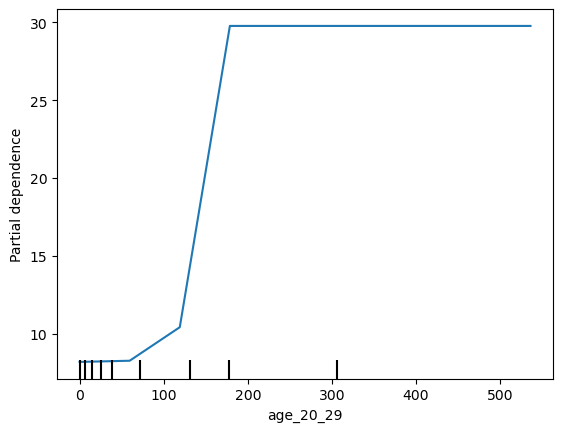

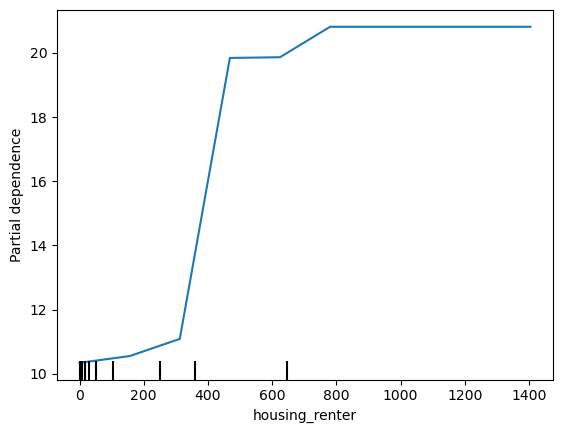

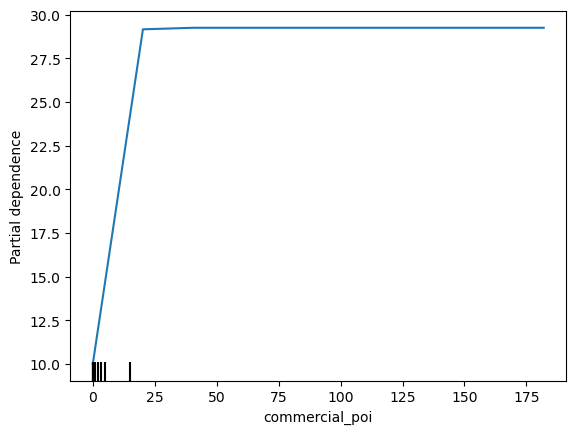

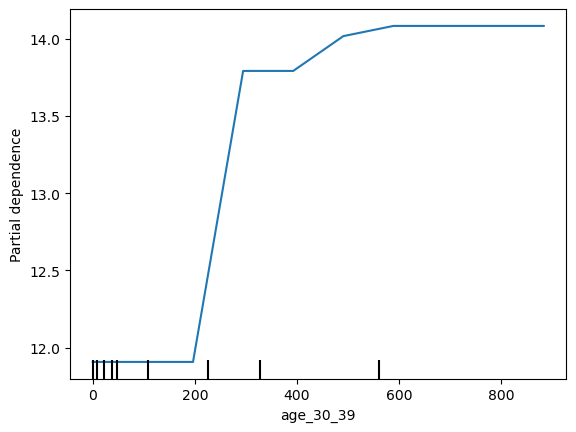

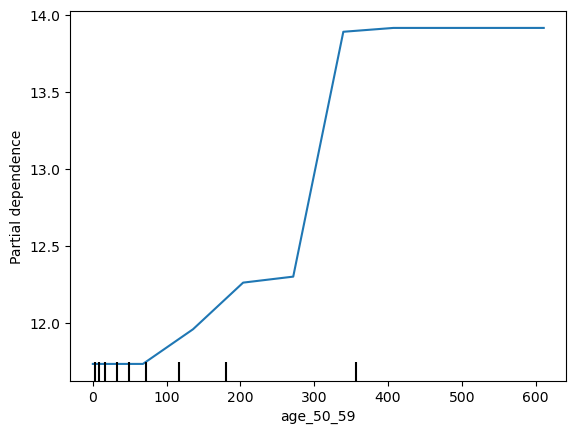

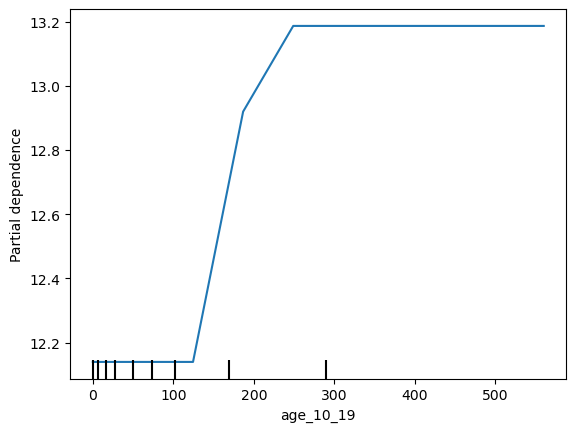

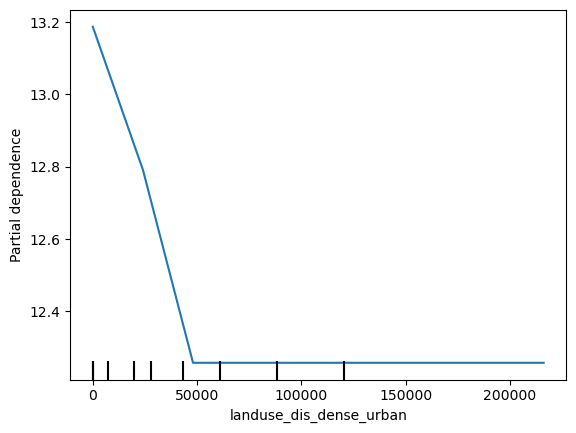

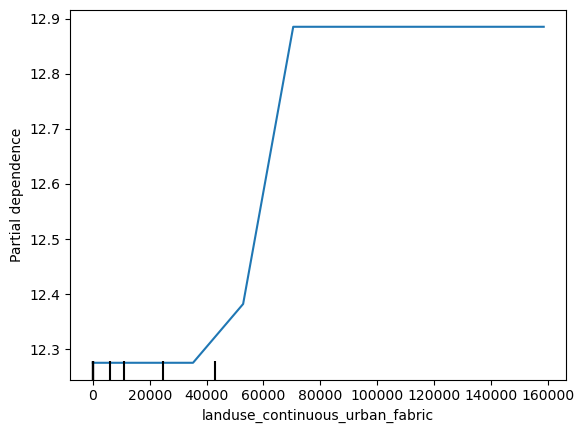

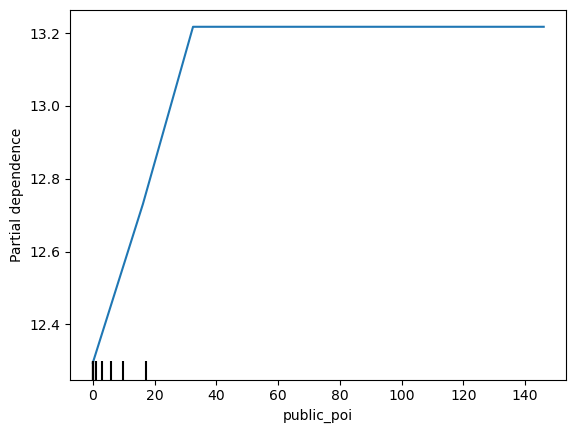

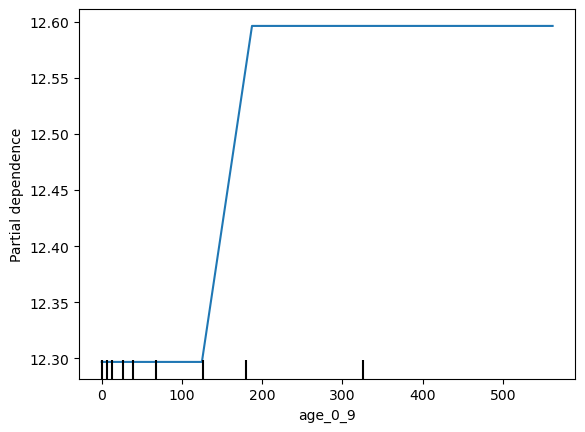

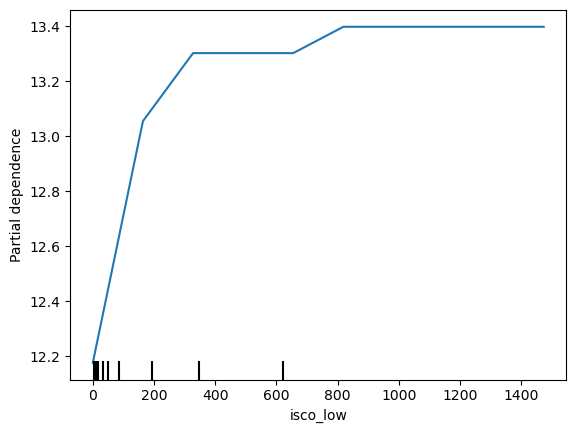

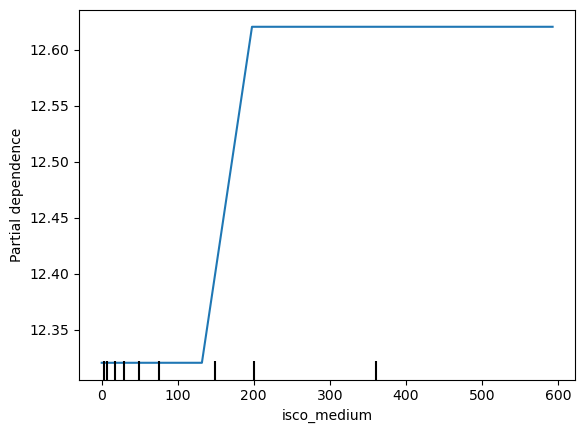

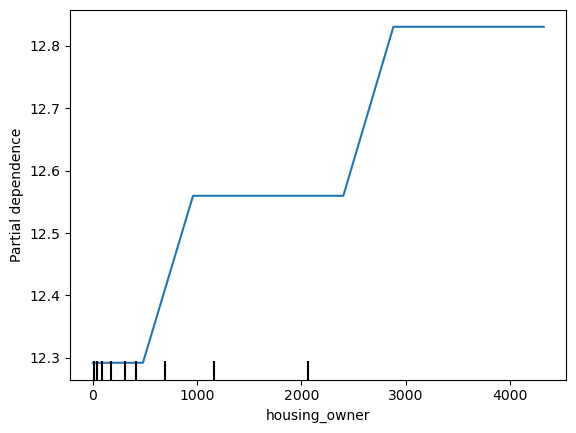

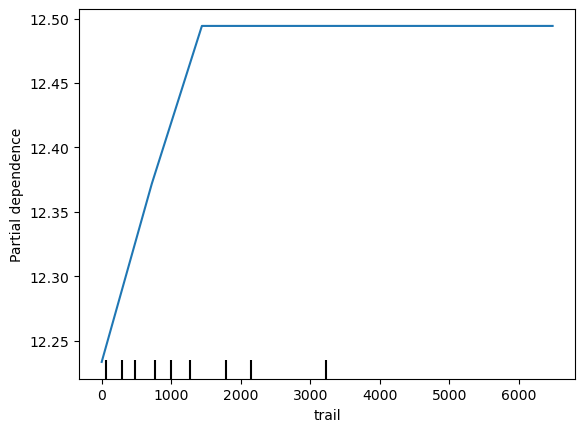

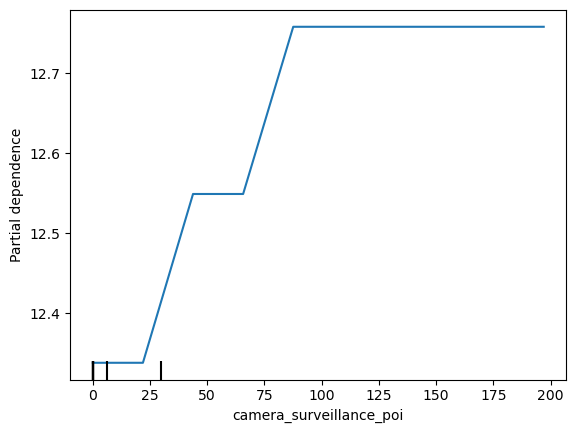

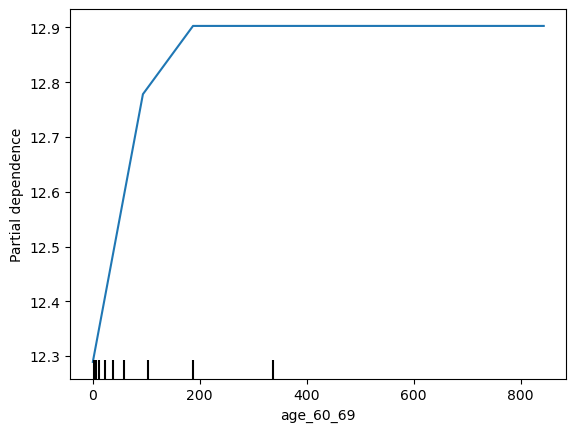

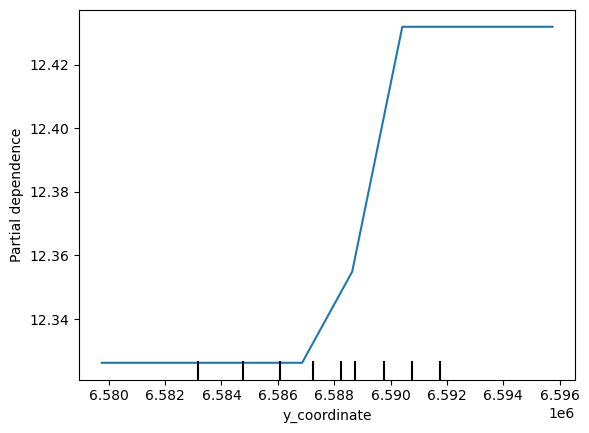

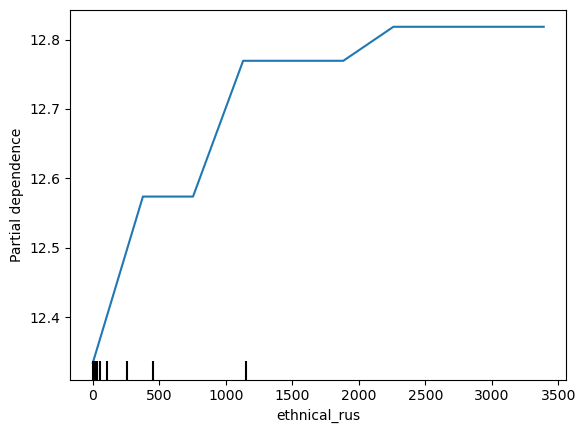

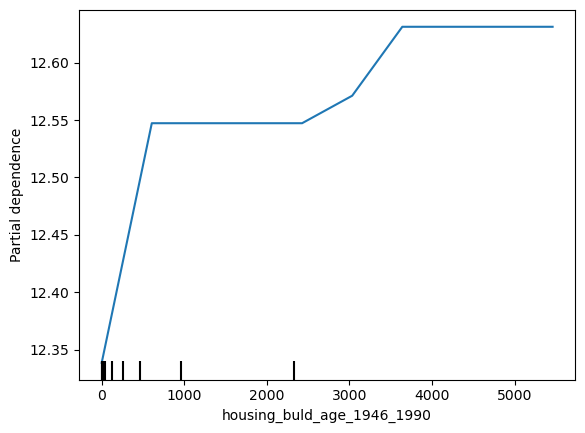

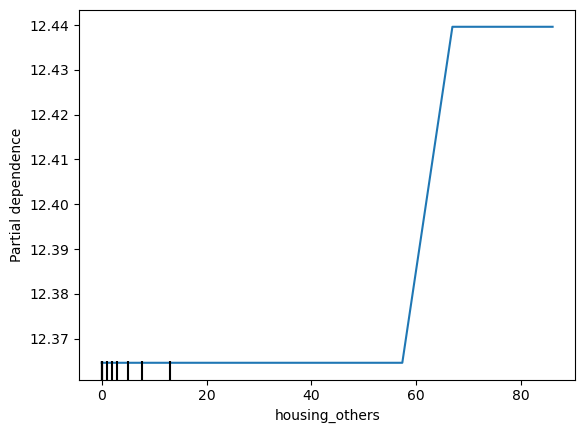

In [34]:
from sklearn.inspection import PartialDependenceDisplay

for pdp in df_forest_importance.index:
    PartialDependenceDisplay.from_estimator(
        reg,
        x_test,
        features=[pdp],
        feature_names=x_columns,
        centered=False,
        kind="average",
        percentiles=(0, 1),
        grid_resolution=10,
    )

## ICE

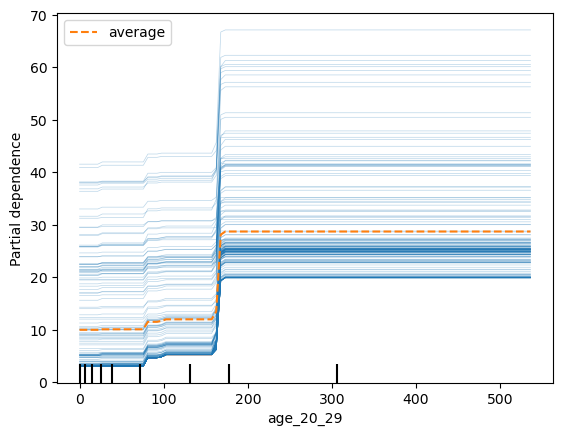

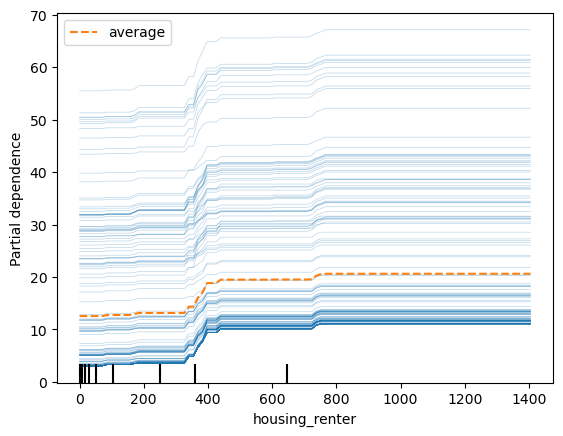

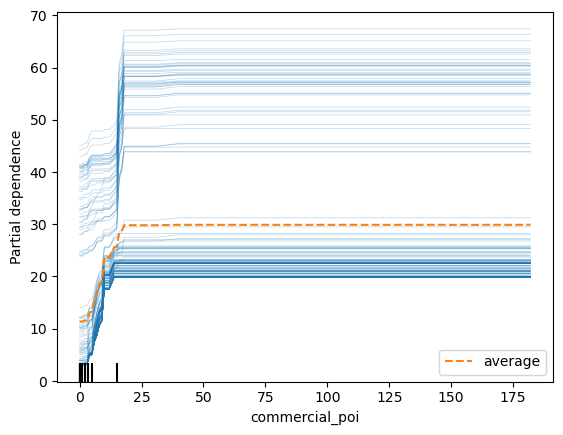

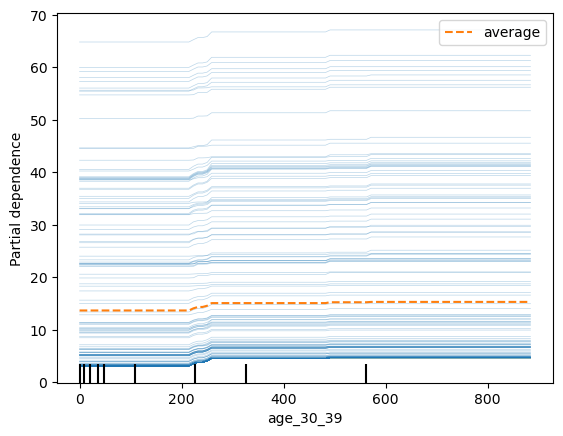

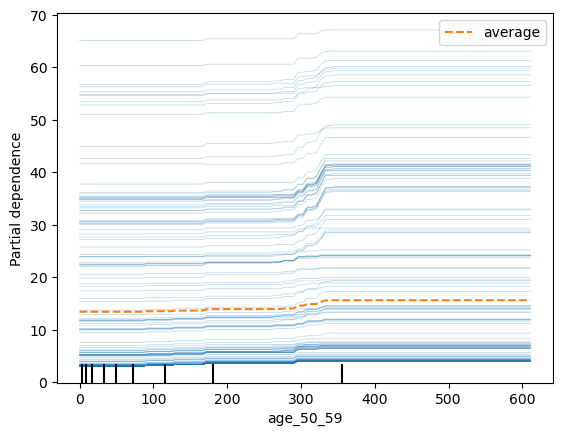

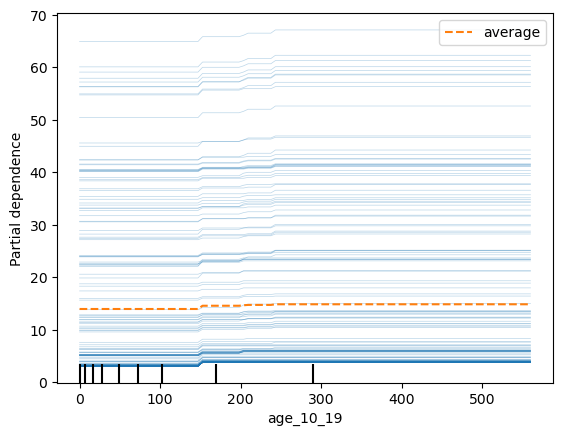

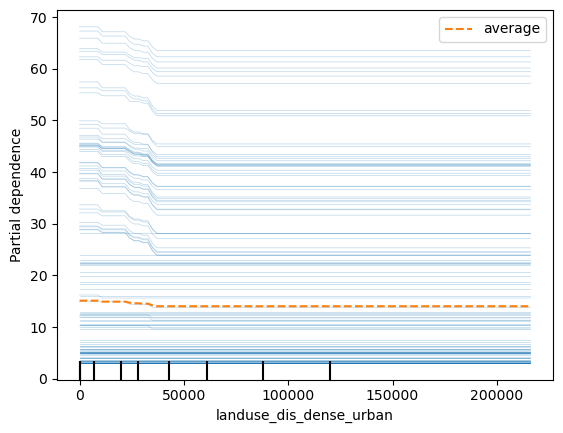

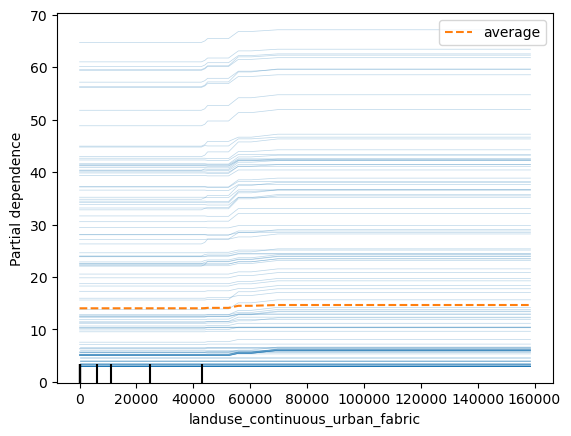

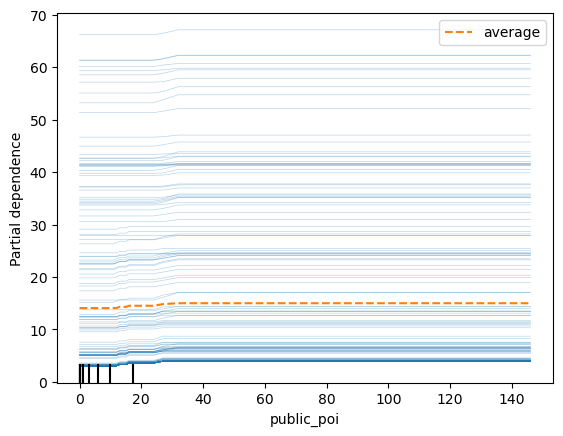

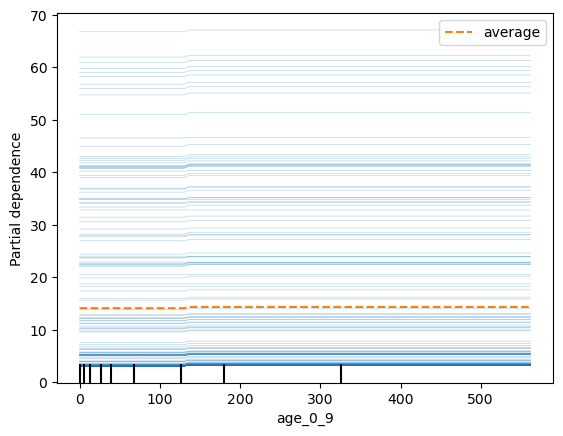

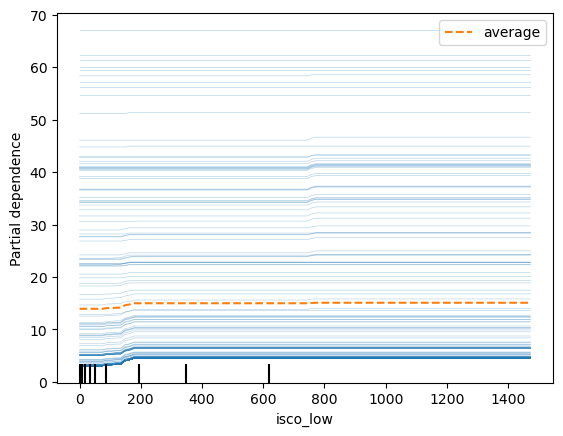

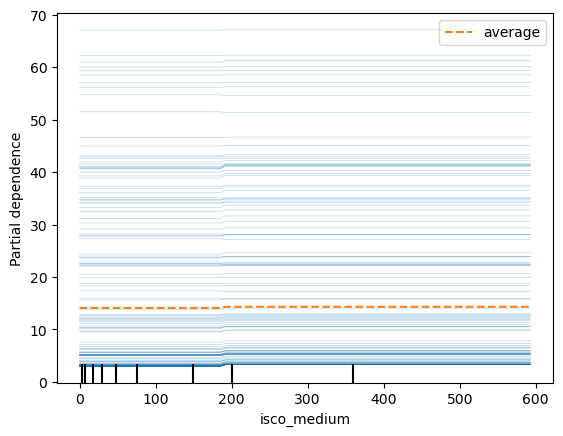

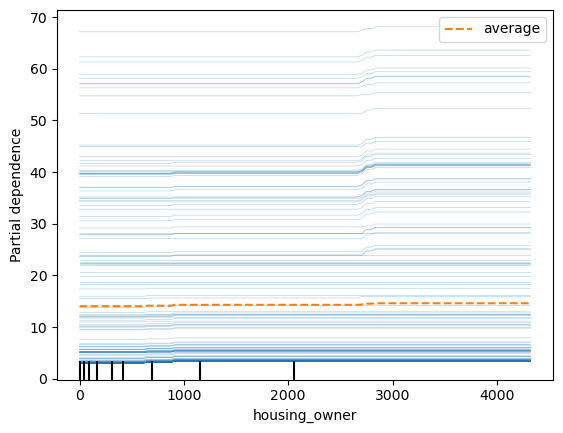

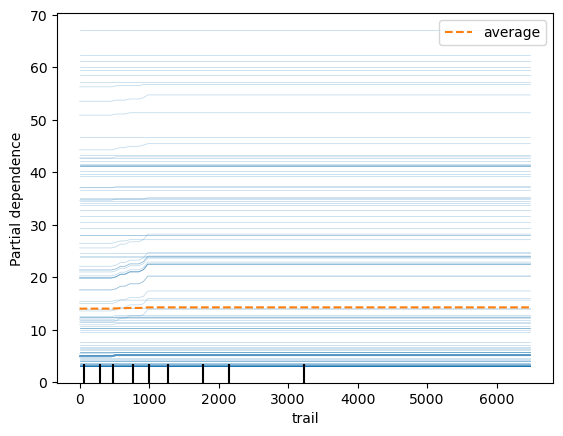

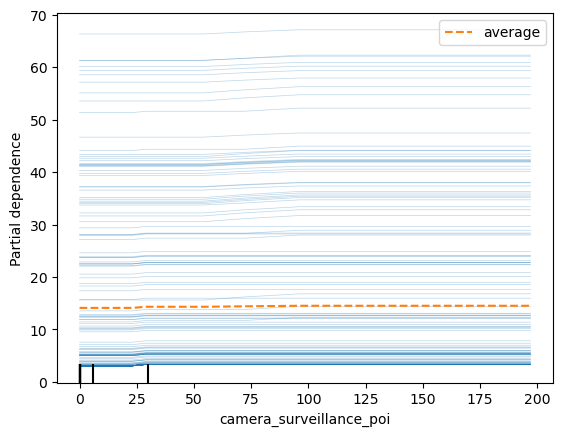

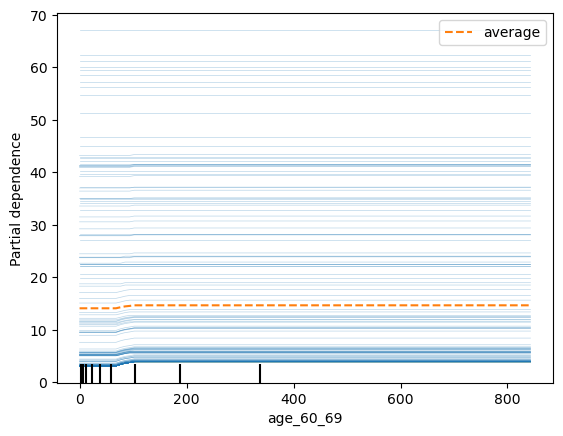

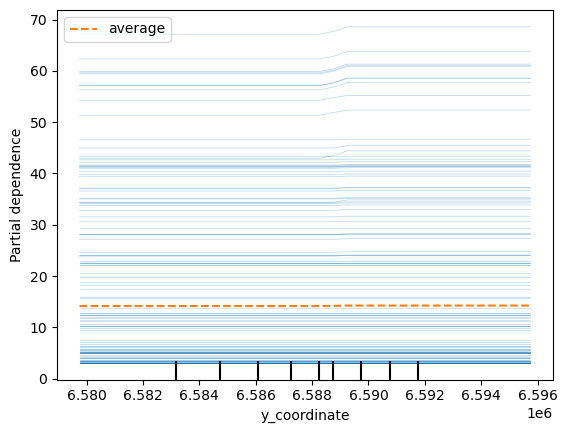

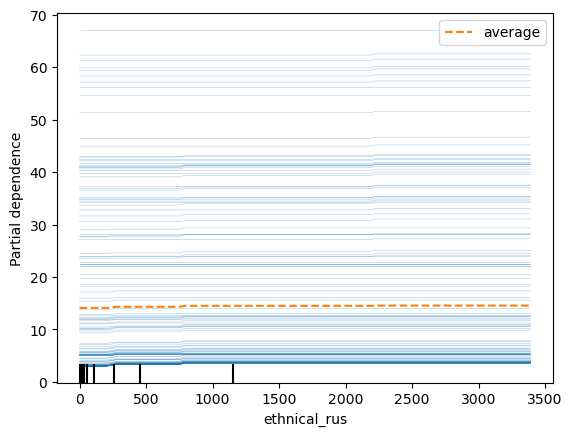

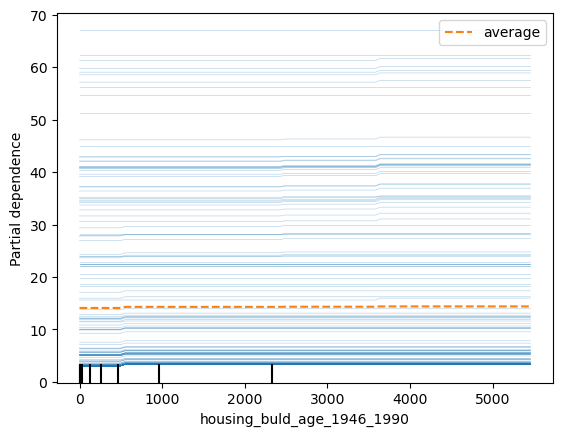

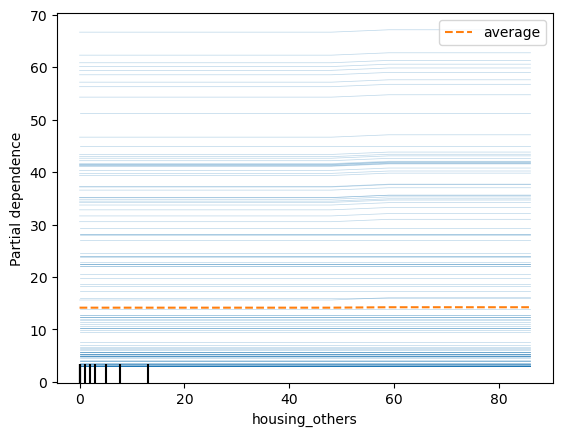

In [35]:
for pdp in df_forest_importance.index:
    PartialDependenceDisplay.from_estimator(
        reg,
        x_test,
        features=[pdp],
        feature_names=x_columns,
        centered=False,
        kind="both",
        percentiles=(0, 1),
        grid_resolution=100,
        
    )